<a href="https://colab.research.google.com/github/sgathai/Capstone-_workings-/blob/main/Edited_Capstone_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAPSTONE PROJECT

Group 4 collaborators:

- Tony Munene
- Loise Mbago
- Immanuel Omondi
- Nazra Nyangwara
- Bahati Ndwiga
- Cleophas Opati
- Stephen Gathai - Team Lead

# DEEP LEARNING IN BREAST CANCER DETECTION

## 1.0 Business Understanding

### 1.1 Background

Breast cancer ranks as the most common cancer globally and the second leading cause of cancer-related deaths. According to the World Health Organization (WHO), breast cancer is the primary cause of mortality among women aged between 45-55 years with an incidence of 1 in 8 women. Early detection and timely intervention play a pivotal role in the prognosis of breast cancer. When detected early, and if adequate diagnosis and treatment are available, the chances of survival increase significantly. Thus, the importance of early detection cannot be overstated, as it can lead to more effective treatments, reduced intervention procedures, and ultimately, lower the risk of breast-cancer-related deaths considerably. Mammography and ultrasound are the primary imaging modalities for the early breast cancer diagnosis. However, these modalities are limited in the extent to which they facilitate early diagnosis. First, follow-up ultrasound, aspiration, or biopsy may need to be performed after a breast ultrasound image is interpreted to determine whether a suspicious abnormality is cancer. Often, most of the suspected problem locations detected by ultrasonography that require biopsy are noncancerous (false positives). Second, many tumors cannot be detected via ultrasonography and annual mammography is still recommended. However, in mammography, some early breast tumors simply manifest as calcifications and go undetected. Therefore, more sophisticated tools are required to overcome the limitations of ultrasound in the early detection of breast cancer.

### 1.2 Problem Statement
The Breast Cancer Research Foundation(BCRF) is seeking to advance breast cancer research by harnessing deep learning to transform early detection and intervention in breast cancer treatment and management. They have engaged our services to design and implement a cutting-edge Deep Learning-Based Breast Cancer Prediction System (DL-BCPS) capable of analyzing medical imaging data, including mammograms and ultrasound images to accurately predict the presence of breast cancer in patients. Through the DL-BCPS, BCRF aims to revolutionize breast cancer research, significantly enhancing both the precision and efficiency of breast cancer diagnosis and providing healthcare professionals with a valuable tool to facilitate timely medical intervention, improve patient outcomes, and support decision-making.

### 1.3 Objectives
- To develop a deep learning model using medical imaging data capable of efficient segmentation of breast masses in ultrasound images.

- To determine specific parameters and features within the medical imaging data that are most indicative of early-stage breast cancer to improve the model's ability to detect cancer at its earliest stages.

- To establish a timeline for medical intervention based on the model's predictions, ensuring that cases with a high likelihood of breast cancer are flagged promptly for further examination and diagnosis.

- To implement a user-friendly interface for healthcare professionals to upload medical images and receive predictions from the DL-BCPS.

### 1.4 Success Criteria
The model should:
- Achieve a classification accuracy of at least 85% on the test dataset.
- Achieve a sensitivity of at least 95% and a specificity of at least 90%
- Have a high F1-score to ensure a balance between precision and recall.
- Demonstrate good generalization by performing well on unseen data.

## 2.0 Data Understanding

The [Breast Ultrasound Images Dataset](https://scholar.cu.edu.eg/?q=afahmy/pages/dataset) includes breast ultrasound images from 600 female patients aged between 25 and 75 years. The dataset consists of 780 images with an average image size of 500 × 500 pixels. The images are in PNG format.

The data is categorized into three sets:

- Benign: This set contains 437 images.
- Malignant: This set contains 210 images.
- Normal: This set contains 133 images.

In [ ]:
#pip install --upgrade numpy

In [ ]:
#pip install --upgrade h5py

In [ ]:
# Import relevant libraries
import os
import random
import warnings
from itertools import chain
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.applications import DenseNet121, InceptionV3, MobileNetV2, ResNet50, VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [ ]:
# Load the dataset from the drive
from google.colab import drive
drive.mount('/content/drive')

# Defining paths to the directories
normal_path = '/content/drive/MyDrive/Breast_cancer_dataset/normal'
benign_path = '/content/drive/MyDrive/Breast_cancer_dataset/benign'
malignant_path = '/content/drive/MyDrive/Breast_cancer_dataset/malignant'
image_dir = '/content/drive/MyDrive/Breast_cancer_dataset'

Mounted at /content/drive


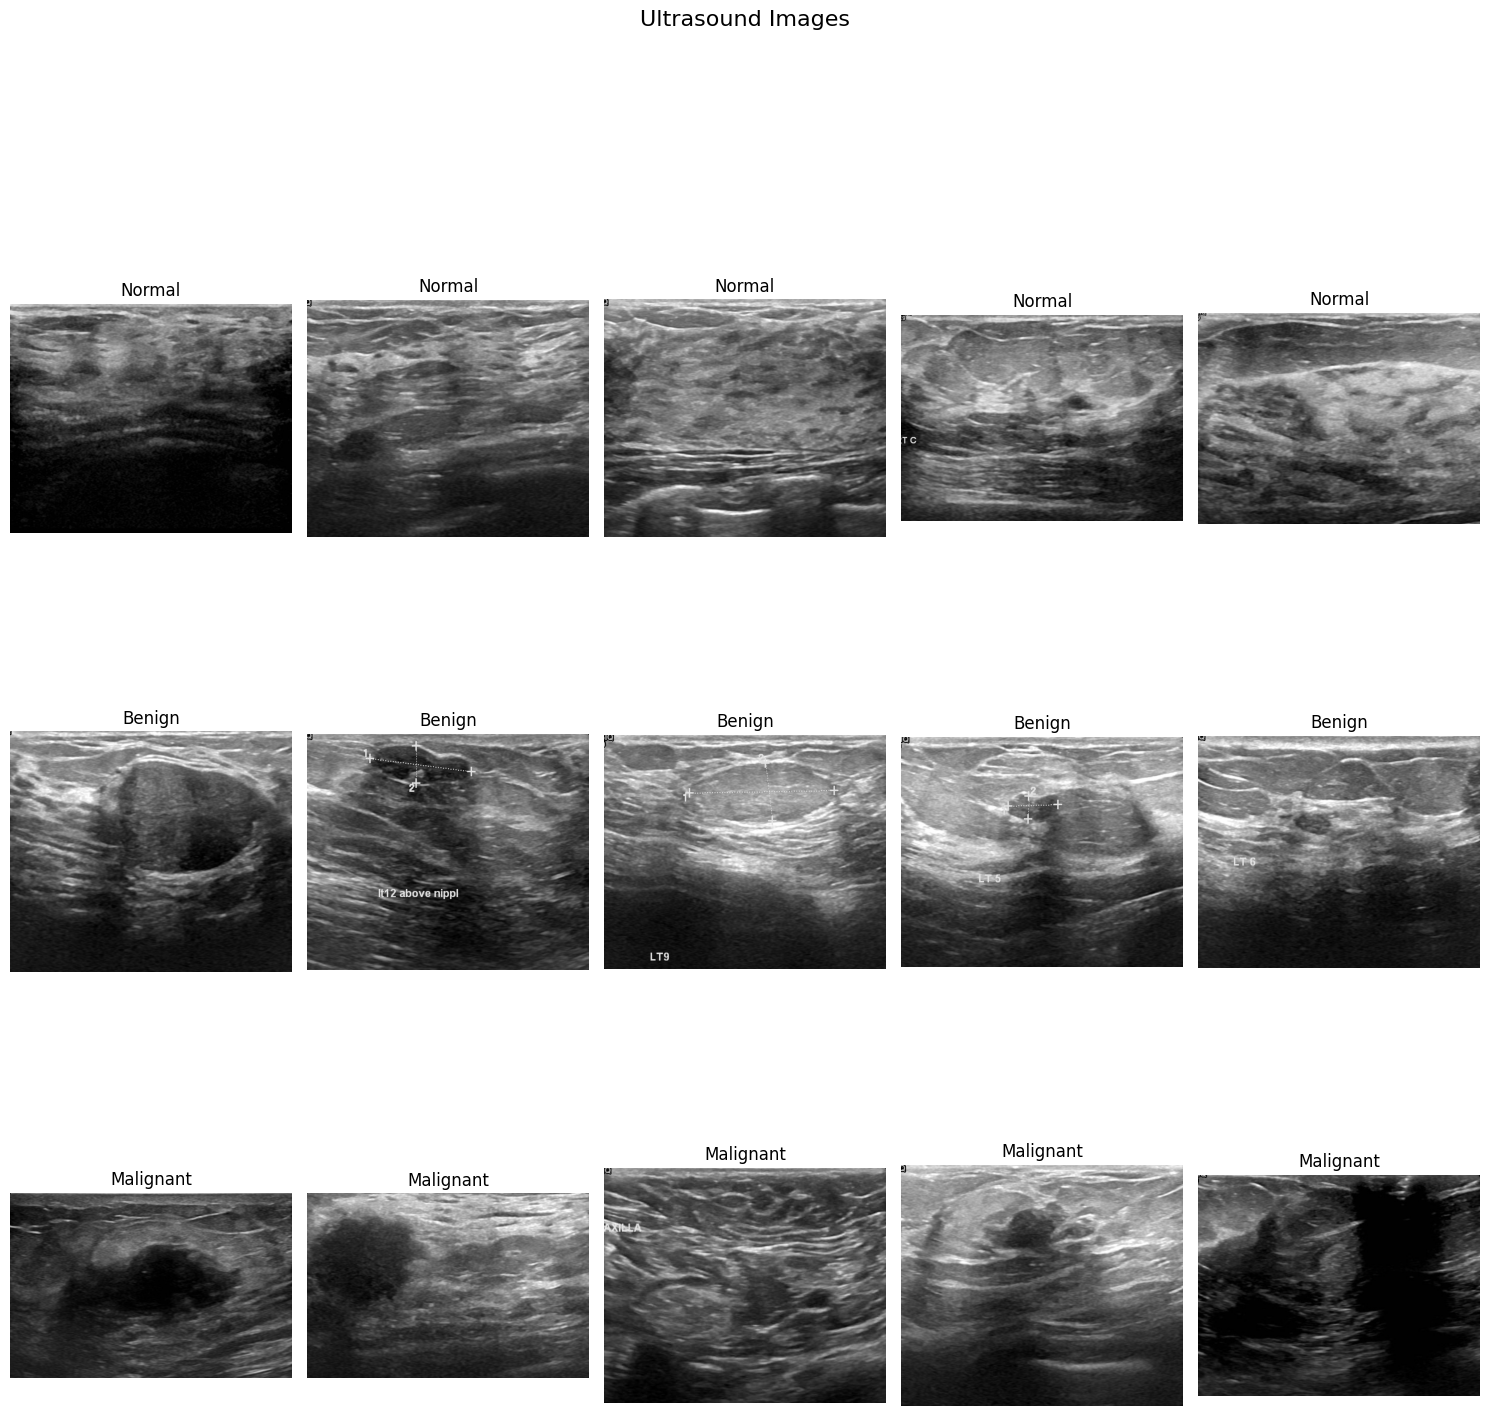

In [ ]:
# Preview sample images

# Create dictionary for categories and paths
categories_paths = {
    'normal': normal_path,
    'benign': benign_path,
    'malignant': malignant_path
}

# Randomly sample 5 images from each category
normal_images = [os.path.join(normal_path, fname) for fname in random.sample(os.listdir(normal_path), 5)]
benign_images = [os.path.join(benign_path, fname) for fname in random.sample(os.listdir(benign_path), 5)]
malignant_images = [os.path.join(malignant_path, fname) for fname in random.sample(os.listdir(malignant_path), 5)]

# Plot images
fig, axes = plt.subplots(3, 5, figsize=(15, 15))
fig.suptitle('Ultrasound Images', fontsize=16, y=1.05)

# Display benign images
for ax, img_path in zip(axes[0], normal_images):
    img = mpimg.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title("Normal")
    ax.axis('off')

# Display malignant images
for ax, img_path in zip(axes[1], benign_images):
    img = mpimg.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title("Benign")
    ax.axis('off')

# Display normal images
for ax, img_path in zip(axes[2], malignant_images):
    img = mpimg.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title("Malignant")
    ax.axis('off')

plt.tight_layout()
plt.show()


Observations:
- The images are already in grayscale hence we will not need to convert them to grayscale
- The images are in different sizes and will need to be resized

In [ ]:
# Check for missing or corrupt images

def check_images(directory):

    corrupt_files = []
    # List all files in the directory
    files = os.listdir(directory)
    for file in files:
        file_path = os.path.join(directory, file)
        try:
            # Try to open the image
            with Image.open(file_path) as img:
                # Check if the image is complete
                img.verify()
        except (IOError, SyntaxError) as e:
            corrupt_files.append(file_path)

    return corrupt_files

# Check each directory for corrupt or missing images
corrupt_normal = check_images(normal_path)
corrupt_benign = check_images(benign_path)
corrupt_malignant = check_images(malignant_path)

# Output the corrupt or missing files
corrupt_files = corrupt_normal + corrupt_benign + corrupt_malignant
if corrupt_files:
    print("Corrupt or missing files:")
    for file_path in corrupt_files:
        print(f" - {file_path}")
else:
    print("No corrupt or missing files found.")


No corrupt or missing files found.


### Image sizes

In this section, we analyze the dimensions of the images in the dataset. Understanding the variation in image sizes will inform the decision on whether to resize images for model training and what target dimensions to use.

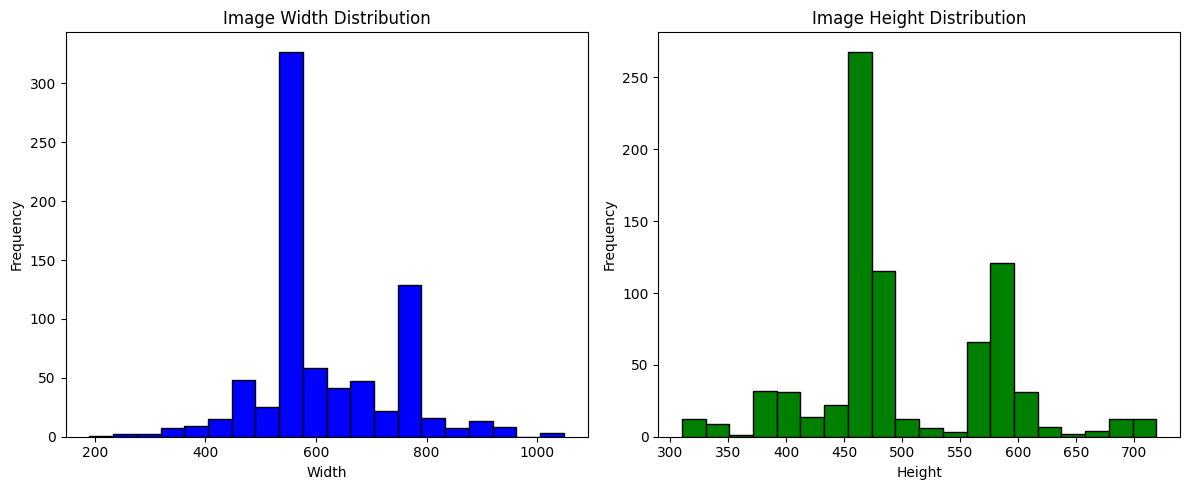

In [ ]:
# Initialize lists to store widths and heights
widths = []
heights = []

# Loop over each category and path
for category, path in categories_paths.items():
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        # Read the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Get the dimensions
        h, w = img.shape
        widths.append(w)
        heights.append(h)

# Plot the Image Size Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(widths, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Image Width Distribution')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Frequency')

axes[1].hist(heights, bins=20, color='green', edgecolor='black')
axes[1].set_title('Image Height Distribution')
axes[1].set_xlabel('Height')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Class distribution

Number of images for each class:
Normal: 133
Benign: 437
Malignant: 210


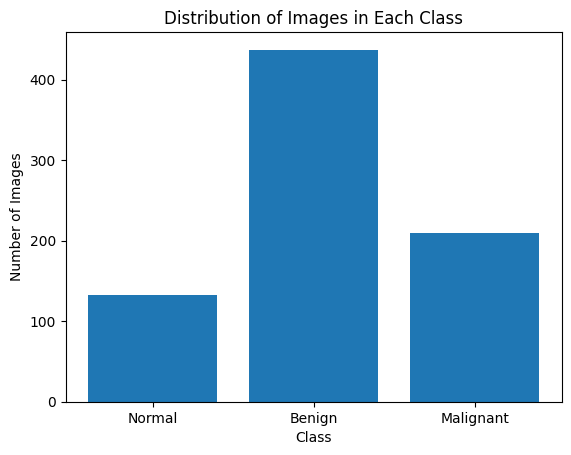

In [ ]:
# Get the list of files in each directory
normal_images = os.listdir(normal_path)
benign_images = os.listdir(benign_path)
malignant_images = os.listdir(malignant_path)

# Count the number of images in each class
num_normal_images = len(normal_images)
num_benign_images = len(benign_images)
num_malignant_images = len(malignant_images)

# Print the counts
print("Number of images for each class:")
print("Normal:", num_normal_images)
print("Benign:", num_benign_images)
print("Malignant:", num_malignant_images)

# Plot a bar chart to visualize the distribution
classes = ['Normal', 'Benign', 'Malignant']
counts = [num_normal_images, num_benign_images, num_malignant_images]

plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.show()

Observation:
- The output above reveals a noticeable class imbalance in the dataset. The benign category is significantly overrepresented compared to the normal and malignant categories. This imbalance will need to be addressed to ensure the model provides a reliable and generalized performance across all classes.

### Mask analysis

In this section we will apply masks to the ultrasound images. This step is crucial for segmenting regions of interest in the images and possibly highlighting areas with cancerous cells.

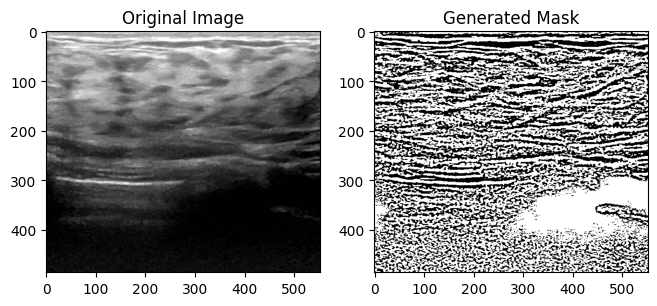

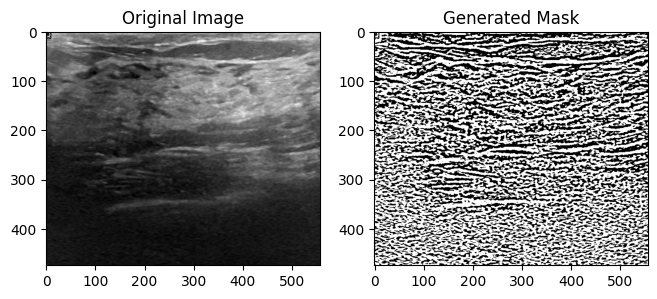

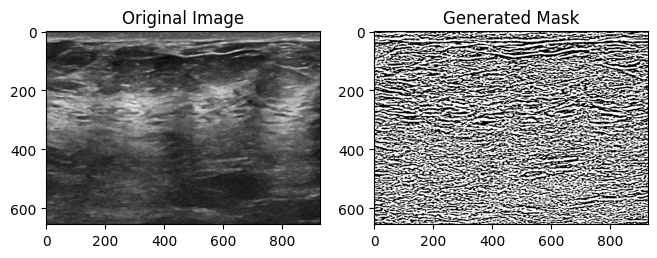

In [ ]:
# Define function to apply masks to original images
def apply_masks(images):
    masked_images = []
    for img in images:
        masked_img = cv2.bitwise_and(img, img, mask=img)
        masked_images.append(masked_img)
    return masked_images

def mask_analysis(image_path):
    try:
        # Get image files in the specified path
        image_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.png')]

        # Load images in grayscale
        images = [cv2.imread(img_f, cv2.IMREAD_GRAYSCALE) for img_f in image_files]

        # Apply adaptive thresholding to isolate cancerous regions
        masks = []
        for img in images:
            mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
            masks.append(mask)

            # Set all non-cancerous regions to black
            mask[mask != 255] = 0

        # Display original images and masked images for a sample of three images
        for i in range(3):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i], cmap='gray')
            plt.title('Original Image')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i], cmap='gray')
            plt.title('Generated Mask')

            plt.show()
    except Exception as e:
        print(f"Error processing images in {image_path}: {e}")

# Display masks of normal images
mask_analysis(normal_path)

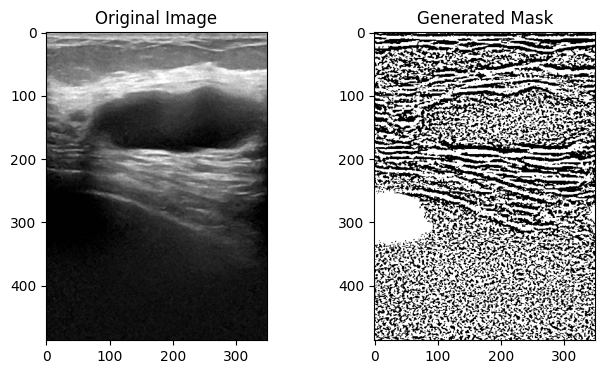

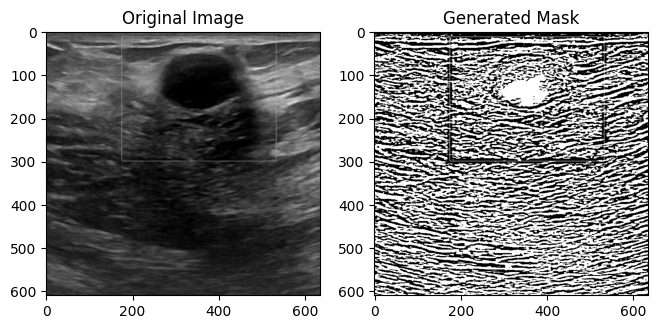

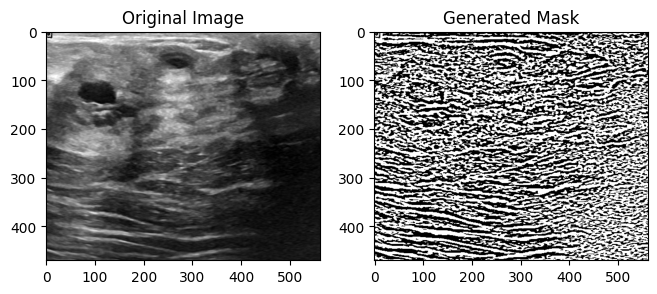

In [ ]:
# Display masks of benign images
mask_analysis(benign_path)

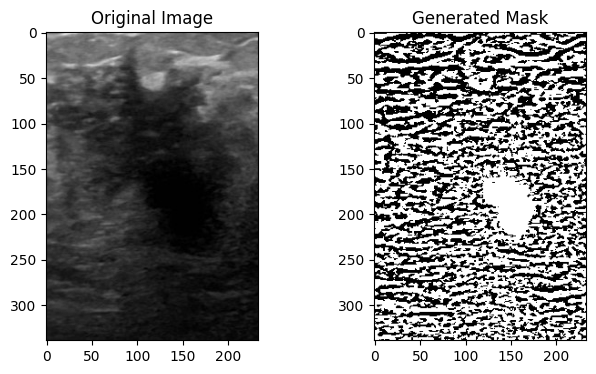

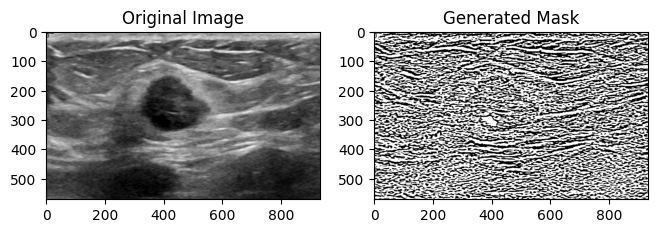

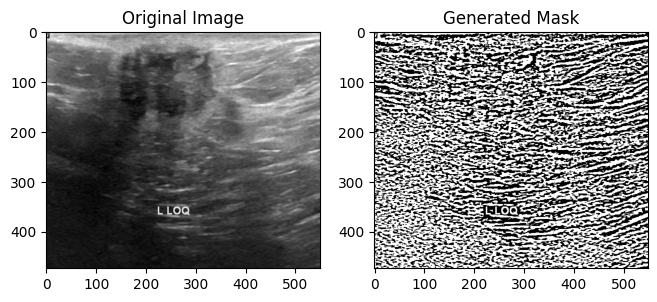

In [ ]:
# Display masks of malignant images
mask_analysis(malignant_path)

## 3.0 Data Preparation

In this section, we will perform several preprocessing steps on the images to prepare them for training. This includes:
- Resizing the images to a consistent size
- Normalizing the pixel values to a range between 0 and 1
- Creating labels for each set
- Addressing class imbalance in the dataset
- Applying data augmentation techniques to increase the variability and size of the training dataset

### a. Resize and normalize images

In [ ]:
# Resize images to 224x224 pixels
img_size = (224, 224)

def load_images(directory):
    images = []
    for fname in os.listdir(directory):
        filepath = os.path.join(directory, fname)
        img = Image.open(filepath)
        img = img.resize(img_size)
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)

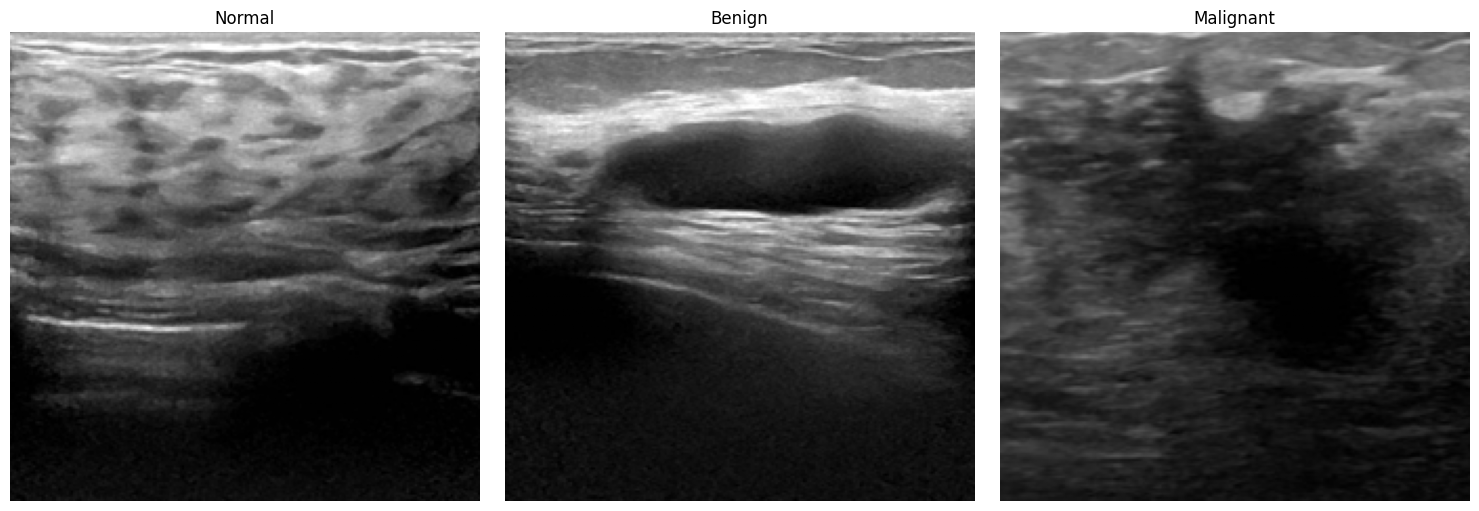

In [ ]:
#Display images after resizing and normalizing

# Load images from each category
normal_images = load_images(normal_path)
benign_images = load_images(benign_path)
malignant_images = load_images(malignant_path)

# Display the first image from each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(normal_images[0])
axes[0].set_title('Normal')
axes[0].axis('off')

axes[1].imshow(benign_images[0])
axes[1].set_title('Benign')
axes[1].axis('off')

axes[2].imshow(malignant_images[0])
axes[2].set_title('Malignant')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### b. Image feature analysis

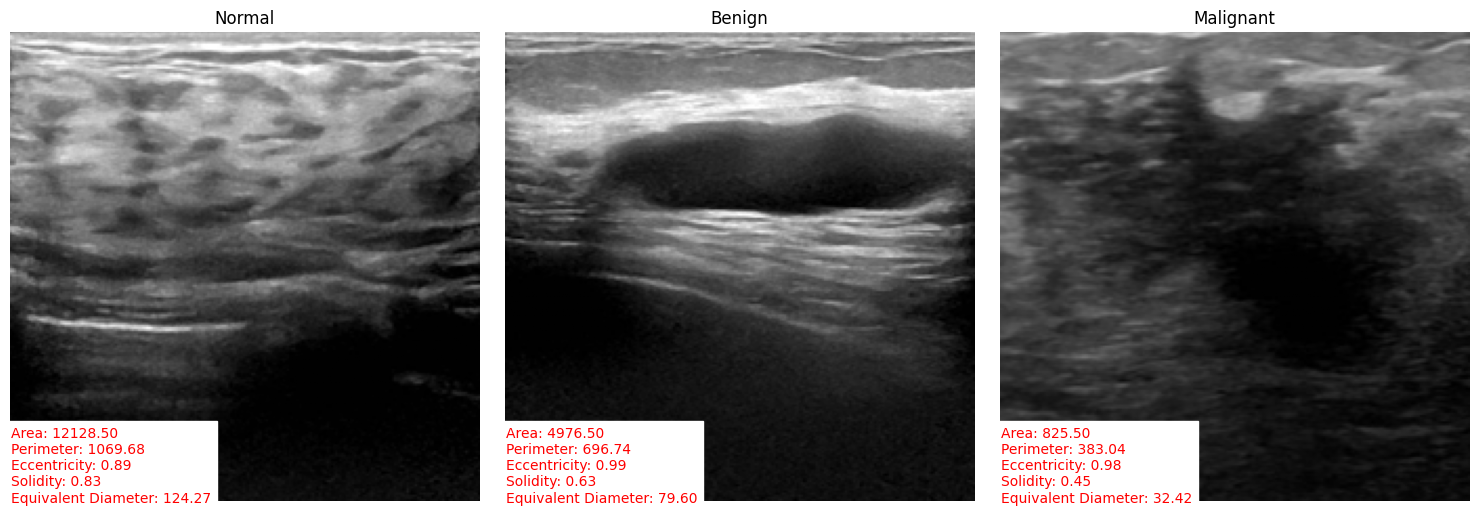

In [ ]:
# Extract shape features from the images
def extract_shape_features(image):
    # Convert the image to float32 if it's in float64
    if image.dtype == np.float64:
        image = image.astype(np.float32)

    # Ensure the image is in grayscale format
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert the image to uint8 type and scale it to 0-255 if necessary
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Apply binary thresholding
    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contours are detected, return None
    if not contours:
        return None

    # Get the largest contour (assuming it's the main object in the image)
    contour = max(contours, key=cv2.contourArea)

    # Extract shape features
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    try:
        ellipse = cv2.fitEllipse(contour)
        (center, axes, orientation) = ellipse
        major_axis_length = max(axes)
        minor_axis_length = min(axes)
        eccentricity = np.sqrt(1 - (minor_axis_length / major_axis_length)**2)
    except:
        eccentricity = 0

    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area

    equivalent_diameter = np.sqrt(4 * area / np.pi)

    return {
        "Area": area,
        "Perimeter": perimeter,
        "Eccentricity": eccentricity,
        "Solidity": solidity,
        "Equivalent Diameter": equivalent_diameter
    }

# Display the first image from each category with shape features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

images = [normal_images[0], benign_images[0], malignant_images[0]]
titles = ['Normal', 'Benign', 'Malignant']

for ax, img, title in zip(axes, images, titles):
    shape_features = extract_shape_features(img)
    display_text = "\n".join([f"{key}: {value:.2f}" for key, value in shape_features.items()])

    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    ax.text(0, 224, display_text, color="red", backgroundcolor="white")

plt.tight_layout()
plt.show()

Feature interpretation:
- **Area**: The benign image has a much larger area compared to both the normal and malignant images. This might suggest that benign tumors or abnormalities are often larger or more spread out in the image than their malignant counterparts. This could also be influenced by the fact that benign tumors grow more slowly and may be detected at a larger size.

- **Perimeter**: The malignant image has the smallest perimeter. This could suggest that malignant tumors or abnormalities may have more irregular, spiky boundaries, leading to a smaller perimeter relative to their area.

- **Eccentricity**: Eccentricity values are closer to 1 for more elongated shapes and closer to 0 for more circular shapes. Both normal and malignant images have high eccentricity values, indicating that they may be more elongated or irregular in shape compared to the benign image which is more circular.

- **Solidity**: A higher solidity value indicates a smoother and more compact shape. The benign image has the highest solidity, suggesting it has a more compact and solid shape, whereas the normal image is more porous or has more internal holes.

- **Equivalent diameter**: The benign image, consistent with its large area, has the largest equivalent diameter. The malignant image, despite having a larger area than the normal image, has a diameter that's not drastically different, possibly due to its irregular shape.

### c. Image data augmentation

Next, we perform data augmentation to further increase the size and variability of the training dataset.

In [ ]:
# Define function to perform data augmentation
def apply_augmentations(image_list, datagen):
    augmented_images = []
    for img_path in image_list:
        img = cv2.imread(img_path)
        if img is None:  # Check if the image was loaded successfully
            continue

        # Reshape the image to fit the expected input shape of datagen.flow
        img = img.reshape((1,) + img.shape)

        # Generate 20 augmented images for each input image
        for _ in range(10):
            for batch in datagen.flow(img, batch_size=1):
                augmented_image = batch[0]
                # Resize the image to ensure consistency
                augmented_image = cv2.resize(augmented_image, (224, 224))
                augmented_images.append(augmented_image.astype(np.uint8))
                break

    return np.array(augmented_images)

# Construct the list of image paths based on image directories
normal_images_paths = glob.glob(os.path.join(normal_path, '*.png'))
malignant_images_paths = glob.glob(os.path.join(malignant_path, '*.png'))
benign_images_paths = glob.glob(os.path.join(benign_path, '*.png'))

all_image_paths = normal_images_paths + malignant_images_paths + benign_images_paths

# Define the parameters for Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Apply augmentations
augmented_images = apply_augmentations(all_image_paths, datagen)
augmented_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in augmented_images]


print(f"Total number of augmented images: {len(augmented_images)}")


Total number of augmented images: 7800


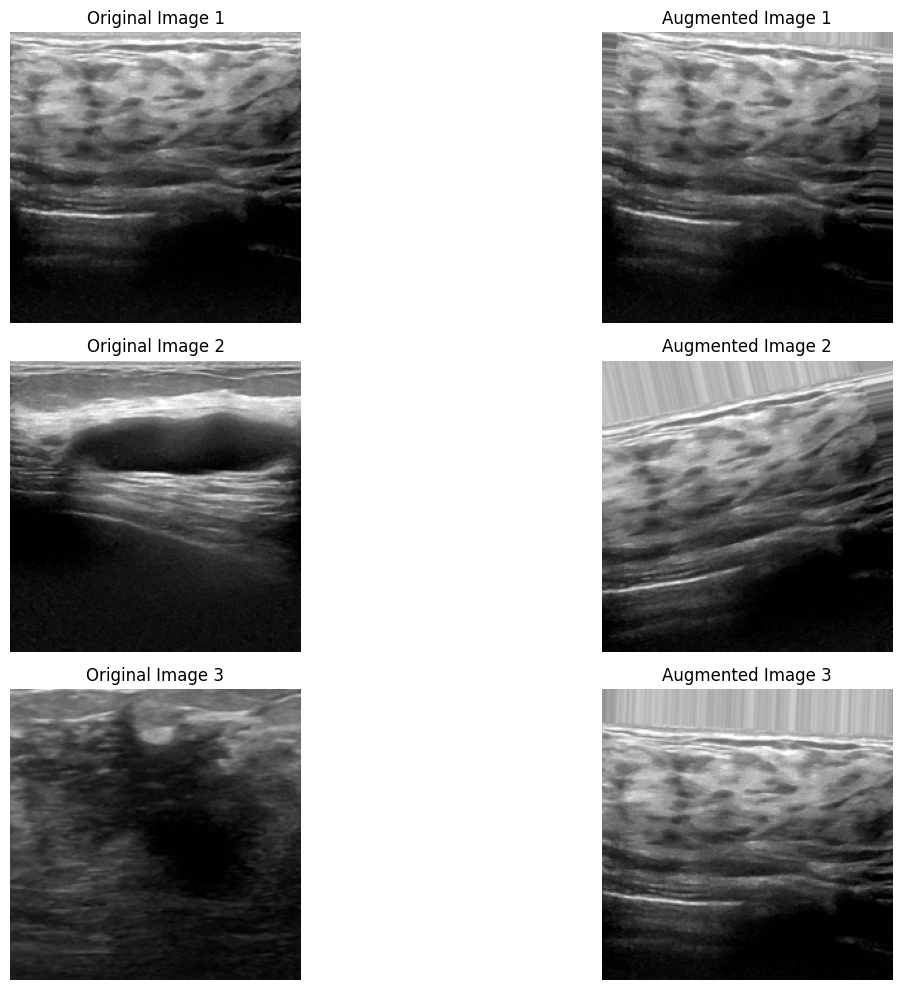

In [ ]:
# Display augmented images alongside original images

# Determine the number of images to display (the minimum of 6, length of images, and length of augmented_images)
num_images = min(6, len(images), len(augmented_images))

# Visualize original images alongside augmented images
plt.figure(figsize=(15, 10))

for i in range(num_images):
    # Original Image
    plt.subplot(num_images, 2, i*2 + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Original Image {i+1}')

    # Augmented Image
    plt.subplot(num_images, 2, i*2 + 2)
    plt.imshow(augmented_images[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Augmented Image {i+1}')

plt.tight_layout()
plt.show()

### d. Create labels

In [ ]:
# Factor for the number of augmented images generated per original image
augmentation_factor = 10

# Create labels: 0 for normal, 1 for benign, 2 for malignant
normal_labels = np.zeros((len(normal_images_paths) * augmentation_factor,), dtype=int)
benign_labels = np.ones((len(benign_images_paths) * augmentation_factor,), dtype=int)
malignant_labels = np.full((len(malignant_images_paths) * augmentation_factor,), 2)

# Concatenate data and labels:

# Resize each image in X to the shape (224, 224)
X_images = [cv2.resize(img, (224, 224)) for img in augmented_images]

# Convert list of images back to numpy array
X = np.array(X_images)

# Expand dimensions to get the shape (7800, 224, 224, 1)
X = np.expand_dims(X, axis=-1)

# Combine the separate label arrays into a single array 'y' that holds all the labels
y = np.concatenate([normal_labels, benign_labels, malignant_labels])


In [ ]:
X.shape

(7800, 224, 224, 1)

In [ ]:
y.shape

(7800,)

### e. Splitting the dataset

In this subsection, we divide our dataset into training, validation, and test sets in the ratios 7:1:2 respectively.

In [ ]:
# Define the ratios
train_ratio = 0.7
validation_ratio = 0.10
test_ratio = 0.20

# # Calculate the sizes of the validation and test sets
# validation_size = validation_ratio / (validation_ratio + test_ratio)
# test_size = test_ratio / (validation_ratio + test_ratio)

# Split the data into a training set and a temporary set for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=1 - train_ratio, random_state=42, stratify=y
)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=test_ratio, random_state=42, stratify=y_temp
)

# Output the shapes to verify the splits
X_train.shape, X_val.shape, X_test.shape

((5459, 224, 224, 1), (1872, 224, 224, 1), (469, 224, 224, 1))

In [ ]:
y_train.shape

(5459,)

# 4.0 Modeling

## 4.1 Baseline CNN Model

In [ ]:
# Define the model
baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Review the model summary
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
# Fit the model
results = baseline_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=70
)

Epoch 1/70
86/86 [==============================] - 79s 906ms/step - loss: 81.4528 - accuracy: 0.5045 - val_loss: 0.9396 - val_accuracy: 0.5753
Epoch 2/70
86/86 [==============================] - 77s 891ms/step - loss: 0.9542 - accuracy: 0.5613 - val_loss: 0.9245 - val_accuracy: 0.5860
Epoch 3/70
86/86 [==============================] - 77s 892ms/step - loss: 0.9126 - accuracy: 0.5842 - val_loss: 0.8707 - val_accuracy: 0.6015
Epoch 4/70
86/86 [==============================] - 77s 889ms/step - loss: 0.8837 - accuracy: 0.5974 - val_loss: 0.8556 - val_accuracy: 0.6132
Epoch 5/70
86/86 [==============================] - 77s 891ms/step - loss: 0.8472 - accuracy: 0.6107 - val_loss: 0.8356 - val_accuracy: 0.6319
Epoch 6/70
86/86 [==============================] - 77s 893ms/step - loss: 0.8387 - accuracy: 0.6131 - val_loss: 0.7794 - val_accuracy: 0.6571
Epoch 7/70
86/86 [==============================] - 77s 891ms/step - loss: 0.8074 - accuracy: 0.6274 - val_loss: 0.7765 - val_accuracy: 0.654

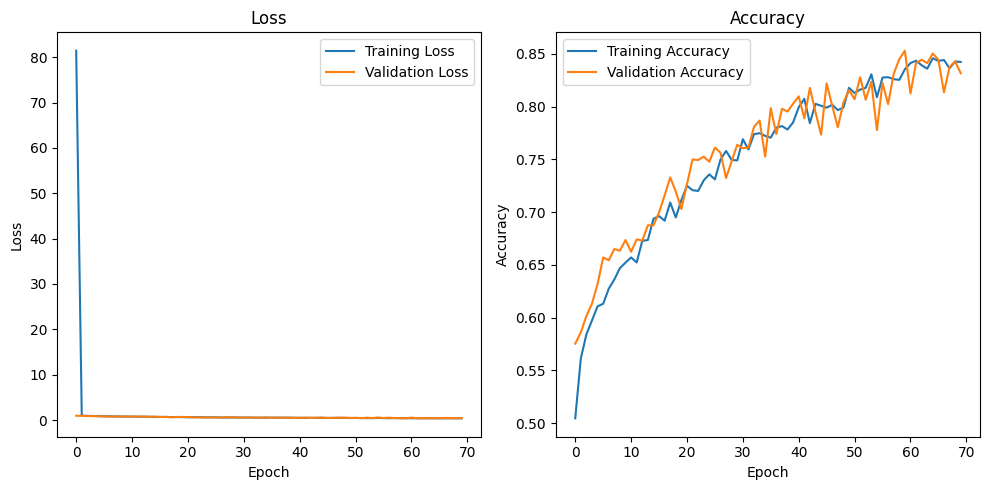

In [ ]:
# Visualize loss and accuracy metrics
training_loss = results.history['loss']
validation_loss = results.history['val_loss']
training_accuracy = results.history['accuracy']
validation_accuracy = results.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = baseline_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

15/15 [==============================] - 1s 77ms/step - loss: 0.4839 - accuracy: 0.8081
Test Loss: 0.4839
Test Accuracy: 0.8081


In [ ]:
# Predict classes for validation set
y_pred = baseline_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes))

59/59 [==============================] - 5s 75ms/step
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       319
           1       0.86      0.87      0.87      1049
           2       0.76      0.76      0.76       504

    accuracy                           0.83      1872
   macro avg       0.82      0.82      0.82      1872
weighted avg       0.83      0.83      0.83      1872



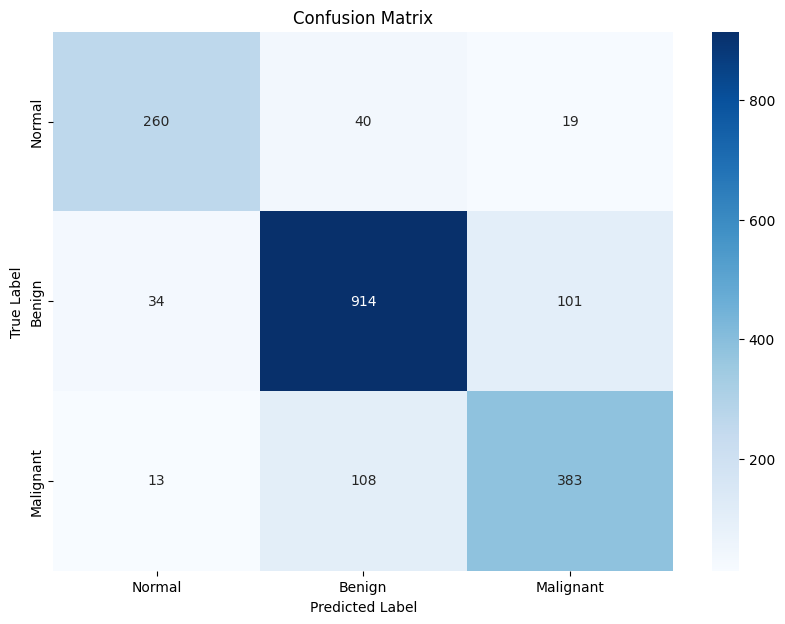

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Normal', 'Benign', 'Malignant'],
            yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 4.2 Baseline model with added layers

In [ ]:
# Define the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_1 = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Flatten and fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(3, activation='softmax')
])

# Compile the model
model_1.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Review the model summary
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)    

In [ ]:
# Fit the model
results_1 = model_1.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=70,
    callbacks = [early_stopping]
)

Epoch 1/70
86/86 [==============================] - 152s 2s/step - loss: 1.3980 - accuracy: 0.4803 - val_loss: 1.8576 - val_accuracy: 0.5091
Epoch 2/70
86/86 [==============================] - 150s 2s/step - loss: 0.9902 - accuracy: 0.5789 - val_loss: 1.2028 - val_accuracy: 0.4856
Epoch 3/70
86/86 [==============================] - 152s 2s/step - loss: 0.9055 - accuracy: 0.6067 - val_loss: 1.0706 - val_accuracy: 0.5000
Epoch 4/70
86/86 [==============================] - 153s 2s/step - loss: 0.8313 - accuracy: 0.6296 - val_loss: 0.7756 - val_accuracy: 0.6608
Epoch 5/70
86/86 [==============================] - 153s 2s/step - loss: 0.7712 - accuracy: 0.6531 - val_loss: 1.5782 - val_accuracy: 0.5096
Epoch 6/70
86/86 [==============================] - 152s 2s/step - loss: 0.7415 - accuracy: 0.6670 - val_loss: 2.4726 - val_accuracy: 0.4327
Epoch 7/70
86/86 [==============================] - 153s 2s/step - loss: 0.7689 - accuracy: 0.6585 - val_loss: 0.8300 - val_accuracy: 0.6458


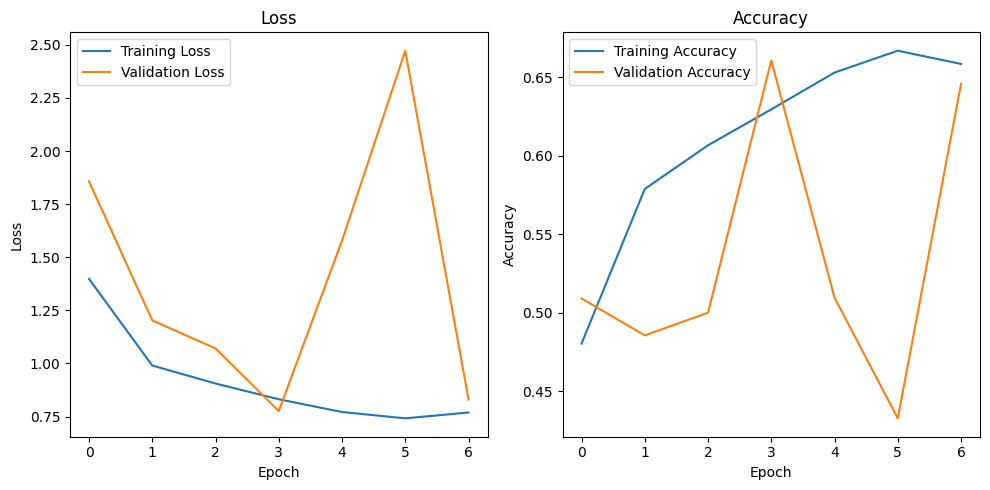

In [ ]:
# Visualize loss and accuracy metrics
training_loss = results_1.history['loss']
validation_loss = results_1.history['val_loss']
training_accuracy = results_1.history['accuracy']
validation_accuracy = results_1.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

15/15 [==============================] - 3s 167ms/step - loss: 0.7946 - accuracy: 0.6546
Test Loss: 0.7946
Test Accuracy: 0.6546


In [ ]:
# Predict classes for validation set
y_pred_1 = model_1.predict(X_val)
y_pred_classes_1 = np.argmax(y_pred_1, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes_1))

59/59 [==============================] - 10s 174ms/step
              precision    recall  f1-score   support

           0       0.60      0.72      0.66       319
           1       0.70      0.82      0.75      1049
           2       0.56      0.30      0.39       504

    accuracy                           0.66      1872
   macro avg       0.62      0.61      0.60      1872
weighted avg       0.65      0.66      0.64      1872



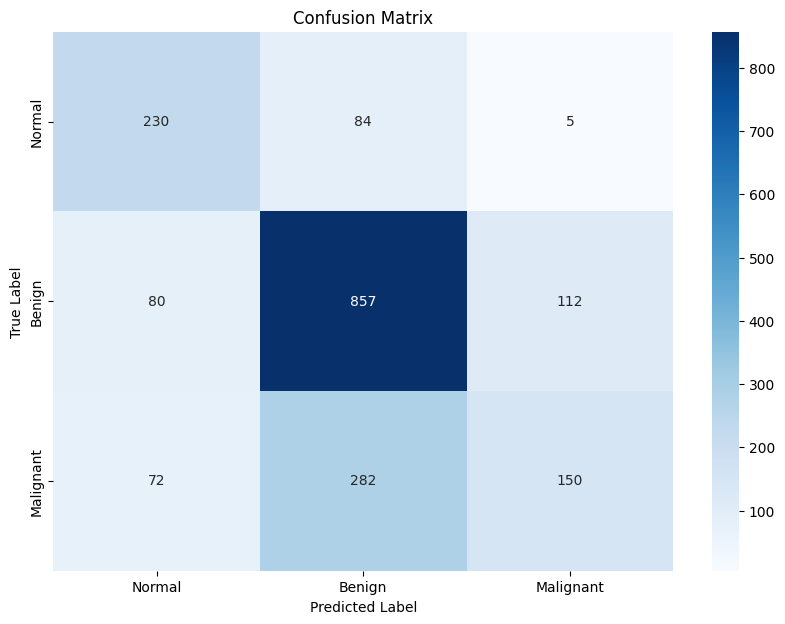

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes_1)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Normal', 'Benign', 'Malignant'],
            yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 4.3 Pretrained model: VGG16

In [ ]:
from keras.models import Model

vgg = VGG16(input_shape = (224, 224, 1), weights=None, include_top=False)

for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
output = Dense(3, activation='softmax')(x)

model_2 = Model(inputs=vgg.input, outputs=output)
model_2.compile(
  loss= 'sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Fit the model
results_2 = model_2.fit(datagen.flow(
    X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=70
)

Epoch 1/70
86/86 [==============================] - 262s 3s/step - loss: 1.0395 - accuracy: 0.5235 - val_loss: 0.9638 - val_accuracy: 0.5582
Epoch 2/70
86/86 [==============================] - 259s 3s/step - loss: 0.9652 - accuracy: 0.5389 - val_loss: 0.9075 - val_accuracy: 0.5796
Epoch 3/70
86/86 [==============================] - 258s 3s/step - loss: 0.9238 - accuracy: 0.5633 - val_loss: 0.8435 - val_accuracy: 0.6074
Epoch 4/70
86/86 [==============================] - 258s 3s/step - loss: 0.8969 - accuracy: 0.5712 - val_loss: 0.8486 - val_accuracy: 0.5839
Epoch 5/70
86/86 [==============================] - 257s 3s/step - loss: 0.9069 - accuracy: 0.5703 - val_loss: 0.8412 - val_accuracy: 0.6175
Epoch 6/70
86/86 [==============================] - 257s 3s/step - loss: 0.8765 - accuracy: 0.5842 - val_loss: 0.8011 - val_accuracy: 0.6325
Epoch 7/70
86/86 [==============================] - 256s 3s/step - loss: 0.9294 - accuracy: 0.5651 - val_loss: 0.8397 - val_accuracy: 0.6010
Epoch 8/70
86

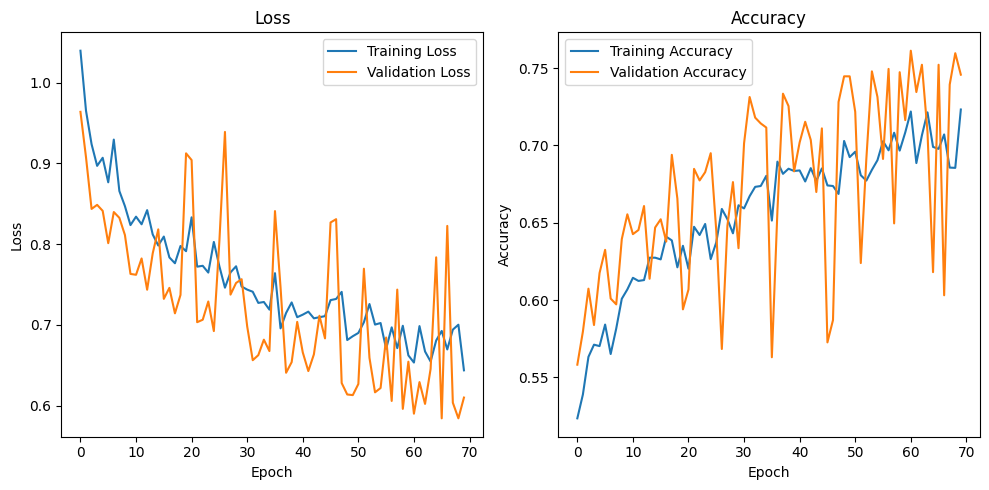

In [ ]:
# Visualize loss and accuracy metrics
training_loss = results_2.history['loss']
validation_loss = results_2.history['val_loss']
training_accuracy = results_2.history['accuracy']
validation_accuracy = results_2.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model_2.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

15/15 [==============================] - 17s 1s/step - loss: 0.6394 - accuracy: 0.7164
Test Loss: 0.6394
Test Accuracy: 0.7164


In [ ]:
# Predict classes for validation set
y_pred_2 = model_2.predict(X_val)
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes_2))

59/59 [==============================] - 67s 1s/step
              precision    recall  f1-score   support

           0       0.63      0.84      0.72       319
           1       0.77      0.90      0.83      1049
           2       0.86      0.37      0.51       504

    accuracy                           0.75      1872
   macro avg       0.75      0.70      0.69      1872
weighted avg       0.77      0.75      0.72      1872



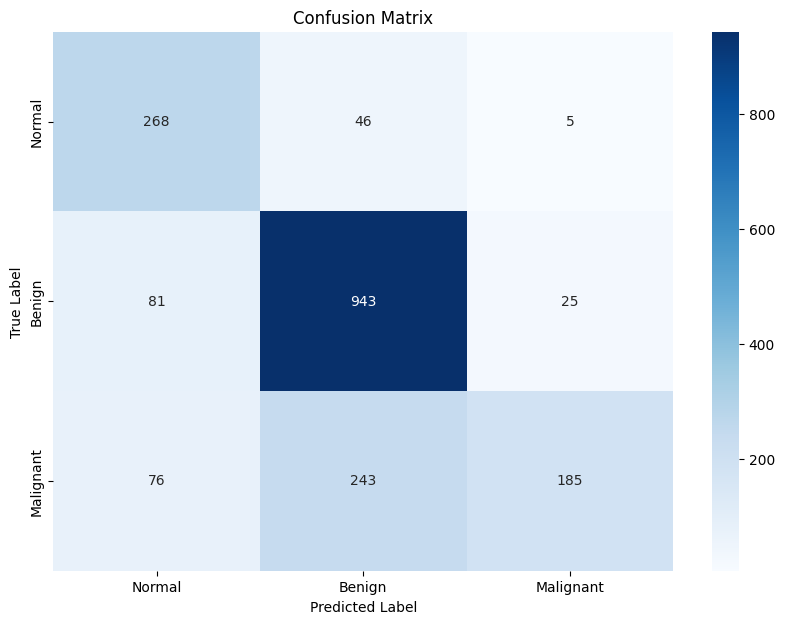

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes_2)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Normal', 'Benign', 'Malignant'],
            yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 5.0 Model Evaluation

## 5.1 Model comparison

In [ ]:
models = [baseline_model, model_1, model_2]
model_names = ["baseline_model", "model_1", "model_2"]
classes = ['normal', 'benign', 'malignant']

# Define a result table as a DataFrame
columns = ['models'] + [f"accuracy_{cls}" for cls in classes] + [f"recall_{cls}" for cls in classes]
result_table = pd.DataFrame(columns=columns)

# Evaluate the models and record the results
for idx, model in enumerate(models):
    model_name = model_names[idx]
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Overall accuracy
    accuracy = accuracy_score(y_val, y_pred_classes)

    # Class-wise recall
    recalls = recall_score(y_val, y_pred_classes, average=None)

    # Construct the results row
    results = {'models': model_name}
    results.update({f"accuracy_{cls}": accuracy for cls in classes})
    results.update({f"recall_{cls}": recalls[i] for i, cls in enumerate(classes)})

    result_table = result_table.append(results, ignore_index=True)

# Set the name of the models as index labels
result_table.set_index('models', inplace=True)

result_table

 1/59 [..............................] - ETA: 9s

<ipython-input-46-bc50aba2517b>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(results, ignore_index=True)


59/59 [==============================] - 8s 133ms/step


<ipython-input-46-bc50aba2517b>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(results, ignore_index=True)


59/59 [==============================] - 65s 1s/step


<ipython-input-46-bc50aba2517b>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(results, ignore_index=True)


accuracy_normal  accuracy_benign  accuracy_malignant  \
models                                                                 
baseline_model         0.831731         0.831731            0.831731   
model_1                0.660791         0.660791            0.660791   
model_2                0.745726         0.745726            0.745726   

                recall_normal  recall_benign  recall_malignant  
models                                                          
baseline_model       0.815047       0.871306          0.759921  
model_1              0.721003       0.816969          0.297619  
model_2              0.840125       0.898951          0.367063

## 5.1 Hyperparameter tuning the best model

In [ ]:
# # Define the model creation function
# def create_model(optimizer='adam'):
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dense(3, activation='softmax')
#     ])
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Define hyperparameters
# optimizers = ['adam']
# batch_sizes = [16, 32, 64]
# epochs_list = [30, 40, 50, 100]

# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# # Grid search
# best_score = 0
# best_params = None

# for optimizer in optimizers:
#     for batch_size in batch_sizes:
#         for epochs in epochs_list:
#             model = create_model(optimizer)
#             history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
#                                 epochs=epochs,
#                                 validation_data=(X_val, y_val),
#                                 callbacks=[early_stopping],
#                                 verbose=0)
#             val_accuracy = max(history.history['val_accuracy'])
#             print(f"Optimizer: {optimizer}, Batch Size: {batch_size}, Epochs: {epochs}, Validation Accuracy: {val_accuracy:.4f}")

#             if val_accuracy > best_score:
#                 best_score = val_accuracy
#                 best_params = (optimizer, batch_size, epochs)

# print("\\nBest Parameters:")
# print(f"Optimizer: {best_params[0]}, Batch Size: {best_params[1]}, Epochs: {best_params[2]}, Best Validation Accuracy: {best_score:.4f}")


In [ ]:
# Tune the parameters on the best performing model
epochs = 50
batch_size=32

# Fit the best performing model
best_results = baseline_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs
)

Epoch 1/50
171/171 [==============================] - 84s 488ms/step - loss: 0.4753 - accuracy: 0.8040 - val_loss: 0.5216 - val_accuracy: 0.7724
Epoch 2/50
171/171 [==============================] - 83s 486ms/step - loss: 0.4476 - accuracy: 0.8119 - val_loss: 0.4317 - val_accuracy: 0.8237
Epoch 3/50
171/171 [==============================] - 83s 483ms/step - loss: 0.4332 - accuracy: 0.8252 - val_loss: 0.4413 - val_accuracy: 0.8194
Epoch 4/50
171/171 [==============================] - 83s 486ms/step - loss: 0.4224 - accuracy: 0.8271 - val_loss: 0.3753 - val_accuracy: 0.8467
Epoch 5/50
171/171 [==============================] - 83s 484ms/step - loss: 0.4089 - accuracy: 0.8313 - val_loss: 0.4265 - val_accuracy: 0.8168
Epoch 6/50
171/171 [==============================] - 82s 481ms/step - loss: 0.4113 - accuracy: 0.8401 - val_loss: 0.5565 - val_accuracy: 0.7692
Epoch 7/50
171/171 [==============================] - 82s 482ms/step - loss: 0.4144 - accuracy: 0.8344 - val_loss: 0.3670 - val_ac

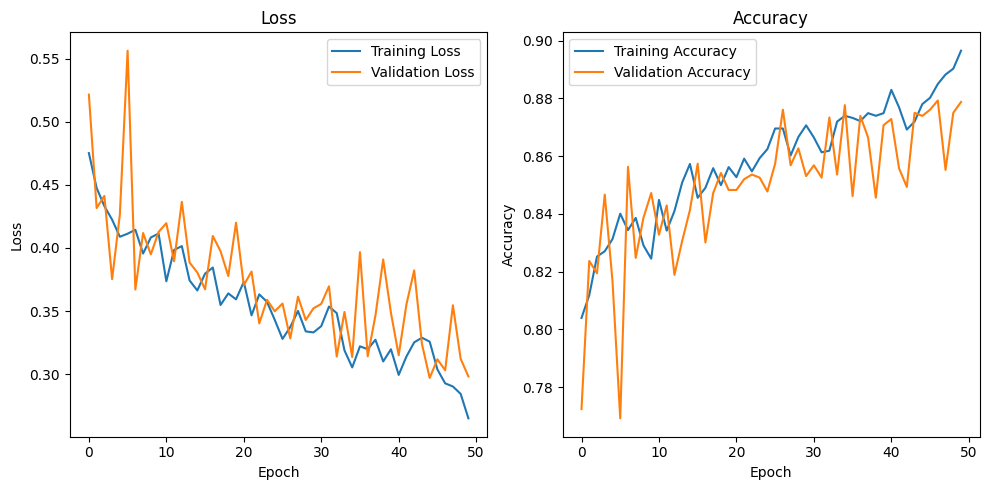

In [ ]:
# Visualize loss and accuracy metrics
training_loss = best_results.history['loss']
validation_loss = best_results.history['val_loss']
training_accuracy = best_results.history['accuracy']
validation_accuracy = best_results.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = baseline_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

15/15 [==============================] - 1s 68ms/step - loss: 0.3179 - accuracy: 0.8699
Test Loss: 0.3179
Test Accuracy: 0.8699


In [ ]:
# Predict classes for validation set
y_pred_3 = baseline_model.predict(X_val)
y_pred_classes_3 = np.argmax(y_pred_3, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes_3))

59/59 [==============================] - 4s 68ms/step
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       319
           1       0.89      0.91      0.90      1049
           2       0.84      0.80      0.82       504

    accuracy                           0.88      1872
   macro avg       0.87      0.87      0.87      1872
weighted avg       0.88      0.88      0.88      1872



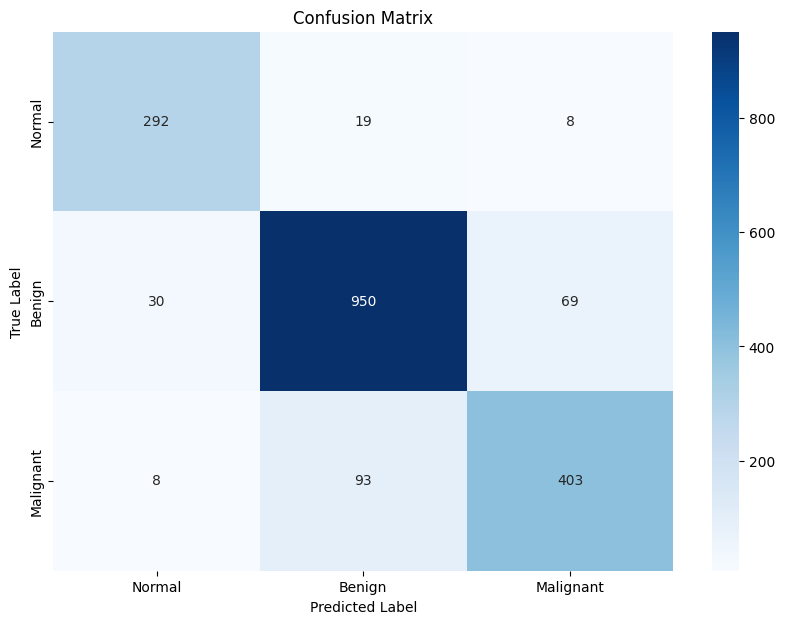

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes_3)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Normal', 'Benign', 'Malignant'],
            yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model
model.save('baseline_model.h5')